In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import os
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.models import load_model
import multiprocessing
from pickle import load
import sklearn
import sklearn.preprocessing 
from get_data_virtual import export_virtual_data
from get_data_cal_ut import generate_data_calibration

In [406]:
current_dir = "./"  # Assuming current directory
dir = "/"
if os.name == "nt":
    current_dir = ".\\"
    dir = "\\"

In [407]:
"---------------------------------------------------------------- PARAMETERS ---------------------------------------------------------------------------------------------"
material = "DP780"
gseed = 6
enu = 0.3
density = 7.85e-9
nb_virtual_pt = 10
degree = 4
weigth_exp = 0.95
weigth_rval = 1
protomodel = "mises"
law = "swift"


gen_v_data = False
gen_e_data = True
adapt = False
export_coeff_abq = True
export_coeff_user = True
plot = True
opti = True

In [408]:
"""----------------------------------------------------------------- GENERATING DATA ----------------------------------------------------------------------------------"""
thetas = ["00", "15", "30", "45", "60", "75", "90"]
materials = ["AA7020-T6", "DP600", "DP780"]
if gen_v_data :
    print("Virtual data generating")
    export_virtual_data(protomodel, material, nb_virtual_pt)
    print("Generation ended")
if gen_e_data:
    print("Processing experimental data")
    generate_data_calibration(material, thetas)
    print("Processing ended")

Processing experimental data
Processing ended


c:\temp\LAB_DATA\get_data_cal_ut.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ut_data = pd.concat([ut_data, row])


In [409]:
""" ----------------------------------------------------------- READ DATA ----------------------------------------------------------------------------------------------"""
def readData(material, protomodel):
    """
        Input :
            - material : string
            - protomodel : string
    """
    filename_v = "data_virtual_" + material + "_" + protomodel + ".csv"
    filepath_v = current_dir + material + "_results" + dir + "DATA" + dir + filename_v

    df_v = pd.read_csv(filepath_v)

    filename_e = "data_cal_" + material + ".csv"
    filepath_e = current_dir + material + "_results" + dir + "DATA" + dir + filename_e

    df_e = pd.read_csv(filepath_e)

    sigma0 = df_e["YieldStress"].iloc[0]

    df_e["s11"] = df_e["YieldStress"] / sigma0 * (np.square(np.cos(df_e["LoadAngle"])) + df_e["q"] * np.square(np.sin(df_e["LoadAngle"])))
    df_e["s22"] = df_e["YieldStress"] / sigma0 * (np.square(np.sin(df_e["LoadAngle"])) + df_e["q"] * np.square(np.cos(df_e["LoadAngle"])))
    df_e["s33"] = df_e["YieldStress"] * 0
    df_e["s12"] = df_e["YieldStress"] / sigma0 * (1 - df_e["q"]) * np.sin(df_e["LoadAngle"]) * np.cos(df_e["LoadAngle"]) / sigma0
    df_e["s13"] = df_e["YieldStress"] * 0
    df_e["s23"] = df_e["YieldStress"] * 0
    
    df = pd.concat([df_e, df_v])
    print(df)

    df["d11"] = (2/3) * df["s11"] - (1/3) * df["s22"] - (1/3) * df["s33"]
    df["d22"] = - (1/3) * df["s11"] + (2/3) * df["s22"] - (1/3) * df["s33"]

    return(df)

df = readData(material, protomodel)
print(df)
nb_virtual_pt = len(df[df["Type"] == "v"])


     q  LoadAngle  YieldStress      Rval Type  YoungMod  Width  Thickness  \
0  0.0        0.0   473.122214  0.822053    e       NaN    NaN        NaN   
1  0.0       15.0   473.972404  0.806049    e       NaN    NaN        NaN   
2  0.0       30.0   483.296154  0.811212    e       NaN    NaN        NaN   
3  0.0       45.0   484.596251  0.855903    e       NaN    NaN        NaN   
4  0.0       60.0   483.774351  0.901318    e       NaN    NaN        NaN   
5  0.0       75.0   489.495251  0.901847    e       NaN    NaN        NaN   
6  0.0       90.0   495.984440  0.878044    e       NaN    NaN        NaN   
7  1.0        0.0   426.500000  0.000000    e       NaN    NaN        NaN   
0  NaN        NaN          NaN  0.000000    v       NaN    NaN        NaN   
1  NaN        NaN          NaN  0.000000    v       NaN    NaN        NaN   
2  NaN        NaN          NaN  0.000000    v       NaN    NaN        NaN   
3  NaN        NaN          NaN  0.000000    v       NaN    NaN        NaN   

In [410]:
"""------------------------ MODEL AND SCALER LOADING -------------------------------------------------"""
number = 1

def custom_activation(x):
    return 0.5 * (1 + tf.math.sign(x)) * (x + 1/100) +  0.5 * (1 - tf.math.sign(x)) * tf.math.exp(tf.math.minimum(0.0,x)) / 100

model = Sequential([])
model.add(Input(shape=(22,)))
model.add(Dense(200, activation=custom_activation, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-7.0, maxval=7.0, seed=gseed)))
model.add(Dense(200, activation=custom_activation))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["accuracy"])

folderpath = f"{current_dir}convexity_domain{dir}NN{dir}"

filename_model = folderpath + f"model_{number}.keras"
filename_weights = folderpath + f"model_weights_{number}.weights.h5"
filename_scaler = folderpath + f"scaler_{number}.pkl"

X_scaler = load(open(filename_scaler, 'rb'))
model.load_weights(filename_weights)

mean = X_scaler.mean_
std = np.sqrt(X_scaler.var_)


#Small test
if degree==2:
    C = np.array([3, 3, 3, 3, 3, 3])
if degree==4:
    C = np.array([9, 18, 27, 18, 9, 18, 18, 18, 9, 18, 18, 18, 18, 9, 0, 0, 18, 18, 18, 18, 18, 9])

print(model.predict(X_scaler.transform(np.atleast_2d(C)))[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1.0


c:\Users\cnober\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [411]:
"""------------------------------------POLYN PARAMETERS---------------------------------------------------------"""

def get_param_polyN(degree):
    """
        Returns the parameters of polyN according to the degree
        Input :
            - degree : integer, degree of the polyN function
        Output :
            - nmon : integer, number of monomials im the polyN function of degree n
            - nmon_abq : integer, number of monomials of degree n in a homogeneous function of degree n
            - powers : ndarray of shape (nmon, 5), powers[i, j] is the power of the variable j in the monomial i
    """
    x0 = np.zeros((2,5))
    polyN = sklearn.preprocessing.PolynomialFeatures((degree, degree), include_bias=False)
    X = polyN.fit_transform(x0)
    powers = polyN.powers_
    nmon_abq = len(powers)

    selected_indices = []
    for i in range(nmon_abq):
        k,l,m,n,p = powers[i]
        if ((m==n) and (n==p)) or ((m%2==0) and (n%2==0) and (p%2==0)):
            selected_indices.append(i)

    powers = powers[selected_indices].T
    X = X[:,selected_indices]

    sorted_indices = np.lexsort((powers[1], powers[2], powers[3], powers[4]))
    powers = powers.T[sorted_indices]
    X = X[:,sorted_indices]

    ndata, nmon = X.shape

    return(powers, nmon, nmon_abq)

powers, nmon, nmon_abq = get_param_polyN(degree)

In [412]:
""" ---------------------------------------------------POLYN DEFINITION------------------------------------------------------------------------------"""
def dev(S):
    """
        Returns the deviatoric stress.
        Input :
            - S : ndarray of shape (n,6) or (6,), stress components in 3D
        Output :
            - D : ndarray of shape (n,6), deviatoric stress components in 3D
    
    """
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = S.copy()
    trace_dev = S[:,0] + S[:,1] + S[:,2]
    D[:,0] = S[:,0] - (1/3) * trace_dev
    D[:,1] = S[:,1] - (1/3) * trace_dev
    D[:,2] = S[:,2] - (1/3) * trace_dev
    return(D)

def polyN(S, coeff):
    """
        Compute the polyN function.
        Input :
            - S : ndarray of shape (n,6) or (6,), stress components in 3D
            - coeff : ndarray of shape (nmon,), coefficients of the polyN function
        Output :
            - res : float, result of polyN
    """
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = dev(S)
    X = D[:,[0, 1, 3, 4, 5]]
    res = np.zeros(len(X))
    for i in range(nmon) :
        p = powers[i]
        res = res + coeff[i] * np.prod(X ** p, axis=1)
    return(res)

"""---------------------------------------------- GRADIENT AND HESSIAN OF POLYN DEFINITION -----------------------------------------------------------"""

#True we lose time here but ok

def jac_dev():
    """
        Returns the jacobian of the deviatoric operator
        Output :
            - jac : ndarray of shape (5,6)
    """
    jac = np.zeros((5, 6))
    jac[0] = np.array([2/3, -1/3, -1/3, 0, 0, 0])
    jac[1] = np.array([-1/3, 2/3, -1/3, 0, 0, 0])
    jac[2] = np.array([0, 0, 0, 1, 0, 0])
    jac[3] = np.array([0, 0, 0, 0, 1, 0])
    jac[4] = np.array([0, 0, 0, 0, 0, 1])
   
    return(jac)

def jac_polyN_param(coeff, powers):
    """
        Compute the different parameters and coefficients to compute the Jacobian of polyN
        Input :
            - coeff (float ndarray of shape (nmon)) : Coefficients of the polyN function
            ordered by power[1] asc, power[2] asc, power[3] asc, power[4] asc
            - powers (float ndarray of shape (nmon, 5)) : Powers for each monomial of the 
            PolyN function
        
        Output :
            - coeff_grad (float ndarray of shape (5, nmon)) : coeff_grad[i,j] contains the 
            coefficients of the monomial j derived with respect to dev[i]
            - powers_grad (float ndarray of shape (5, nmon, 5)) : powers_grad[i,j] contains
            the monomial j derived with respect to dev[i]
    """

    coeff_grad = np.zeros((5, coeff.shape[0]))
    powers_grad = np.zeros((5, powers.shape[0], powers.shape[1]))
    for i in range(5):
        coeff_grad[i] = coeff * powers[:,i]
        subs = np.zeros(powers_grad[i].shape)
        subs[:,i] = -1
        powers_grad[i] = np.maximum(0,powers + subs)
    
    return(coeff_grad, powers_grad)

def grad_polyN(S, coeff_grad, powers_grad):
    """
        Input :
            - S : float ndarray of shape (n, 6) or (6,), stress components in 3d
            - coeff_grad : float ndarray of shape (5, nmon),coeff_grad[i] contains the 
            coefficients of each monomial derived with respect to dev[i]
            - powers_grad : float ndarray of shape (5, nmon, 5) : powers_grad[i][j] contains
            the monomial j derived with respect to i-th deviatoric component
        
        Output :
            - grad : ndarray of shape (n, 6), grad_polyN[i, j] = dpolyN/dsj of the i-th data
    """
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = dev(S)
    X = D[:,[0, 1, 3, 4, 5]]

    grad_polyN = np.zeros(6)
    grad_f = np.zeros((len(X),5))

    for i in range(5):
        for j in range(nmon):
            p = powers_grad[i][j]
            grad_f[:,i] = grad_f[:,i] + coeff_grad[i][j] * np.prod(X ** p, axis=1)
    
    jac_d = jac_dev()

    grad_polyN = np.dot(grad_f, jac_d)
    return(grad_polyN)

def hessian_polyN_param(coeff_grad, powers_grad):
    """
    Compute the different parameters and coefficients to compute the Hessian of polyN
        Input :
            - coeff_grad : float ndarray of shape (5, nmon), coeff_grad[i] contains the 
            coefficients of dpolyN/ddev[i]
            - powers_grad : float ndarray of shape (5, nmon, 5), powers_grad[i,j] contains
            the powers of dmon[j]/ddev[i]
        
        Output :
            - coeff_hessian : float ndarray of shape (5, 5, nmon)), coeff_hessian[i,j,k] contains
            the coefficients of d2mon[k]/ddev[j]ddev[i] 
            - powers_hessian : float ndarray of shape (5, 5, nmon, 5), powers_hessian[i,j,k]contains
            the powers of d2mon[k]/ddev[j]ddev[i] 

    """
    coeff_hessian = np.zeros((5, coeff_grad.shape[0], coeff_grad.shape[1]))
    powers_hessian = np.zeros((5, powers_grad.shape[0], powers_grad.shape[1], powers_grad.shape[2]))

    for i in range(5):
        for j in range(5):
            coeff_hessian[i][j] = coeff_grad[i] * powers_grad[i,:,j]
            subs = np.zeros(powers_hessian[i][j].shape)
            subs[:,j] = -1
            powers_hessian[i][j] = np.maximum(0,powers_grad[i] + subs)
    
    return(coeff_hessian, powers_hessian)

def hessian_polyN(S, coeff_hessian, powers_hessian):
    """
        Compute the hessian of polyN.
        Input :
            - S : float ndarray of shape (n, 6) or (6,), stress components in 3d
            - coeff_hessian : float ndarray of shape (5, 5, nmon)), coeff_hessian[i,j,k] contains
            the coefficients of d2mon[k]/ddev[j]ddev[i] 
            - powers_hessian : float ndarray of shape (5, 5, nmon, 5), powers_hessian[i,j,k]contains
            the powers of d2mon[k]/ddev[j]ddev[i] 
        Output :
            - hessian : float ndarray of shape (n, 6, 6), hessian[i,j,k] = dpolyN/ds[k]ds[j] of the ith data pt

    """
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = dev(S)
    X = D[:,[0, 1, 3, 4, 5]]

    hessian_polyN = np.zeros((6,6))
    jac_grad_f = np.zeros((len(X), 5, 5))

    for i in range(5):
        for j in range(5):
            for k in range(nmon):
                p = powers_hessian[i][j][k]
                jac_grad_f[:,i,j] = jac_grad_f[:,i,j] + coeff_hessian[i][j][k] * np.prod(X ** p, axis=1)
    
    jac_d = jac_dev(S)
    hessian_polyN = np.transpose(np.dot(jac_d.T,np.dot(jac_grad_f[:], jac_d)), (1, 2, 0))
    return(hessian_polyN)

In [413]:
""" ---------------------------------------------PARAMETERS OPTIMIZATION-----------------------------------------------------------------------------"""

if degree==2:
    C = np.array([3, 3, 3, 3, 3, 3])
if degree==4:
    C = np.array([9, 18, 27, 18, 9, 18, 18, 18, 9, 18, 18, 18, 18, 9, 0, 0, 18, 18, 18, 18, 18, 9])

def optiCoeff_polyN(df, degree, weigth_exp):
    """
    
    """
    data = df[["d11", "d22", "s12", "s13", "s23"]].values
    polyN = sklearn.preprocessing.PolynomialFeatures((degree, degree), include_bias=False)
    X_stress = polyN.fit_transform(data)
    powers = polyN.powers_

    selected_indices = []
    for i in range(nmon_abq):
        k,l,m,n,p = powers[i]
        if ((m==n) and (n==p)) or ((m%2==0) and (n%2==0) and (p%2==0)):
            selected_indices.append(i)

    powers = powers[selected_indices].T
    X_stress = X_stress[:,selected_indices]

    sorted_indices = np.lexsort((powers[1], powers[2], powers[3], powers[4]))
    powers = powers.T[sorted_indices]
    X_stress = X_stress[:,sorted_indices]

    ndata = len(data)

    #RVALUE
    index_rval = np.where(df["Rval"]< 0.00001, False, True) #RVALUE SIGNIFICANT IF NOT ZERO
    ndata_rval = np.count_nonzero(index_rval)
    dX_stress_dev = np.zeros((ndata_rval, 5, nmon))
    X_stress_rval = data[index_rval]
    param = df[["Rval", "q", "LoadAngle"]].iloc[index_rval].values
    coeff_mon = np.ones(22)
    coeff_dmon, powers_dmon = jac_polyN_param(coeff_mon, powers)

    for j in range(5):
        for k in range(nmon):
            p = powers_dmon[j, k]
            dX_stress_dev[:, j, k] = dX_stress_dev[:, j, k] + coeff_dmon[j, k] * np.prod(X_stress_rval ** p, axis = 1)

    dX_stress_stress = np.zeros((ndata, 6, nmon))

    jac_d = jac_dev()

    for i in range(ndata_rval):
        dX_stress_stress[i] = np.dot(jac_d.T, dX_stress_dev[i])

    X_rval = np.zeros((ndata_rval, nmon))
    for i in range(ndata_rval):
        rval, q, theta = param[i]
        v = np.array([rval + np.square(np.sin(theta)), rval + np.square(np.cos(theta)), 0,  -np.cos(theta) * np.sin(theta), 0, 0])
        X_rval[i] = np.dot(v, dX_stress_stress[i])
    
    weigth_s = np.where(df["Type"] == "e", weigth_exp, 1-weigth_exp)
    weigth_r = np.ones(ndata_rval) * weigth_rval

    weigth = np.concatenate((weigth_s, weigth_r), axis = 0)
    print(weigth)
    
    

    print(X_stress.shape, X_rval.shape)
    v = np.concatenate((X_stress, X_rval), axis = 0)
    d = np.concatenate((np.ones(ndata), np.zeros(ndata_rval)))

    M = np.zeros((nmon, nmon))
    for j in range(v.shape[0]):
        vj = np.expand_dims(v[j], axis=0)
        M = M + weigth[j] * np.dot(vj.T, vj)
    M = M / 2

    V = np.zeros(v.shape[1])
    for j in range(v.shape[1]):
        vj = v[j]
        V = V + weigth[j] * d[j] * vj

    D = np.sum(weigth * np.square(d)) / 2
    
    def J(a):
        return np.dot(np.dot(a, M), a) - np.dot(V, a) + D

    def Grad_J(a):
        return np.dot(grad_scaler, 2 * np.dot(M, a) - V)

    def J_norm(a_norm):
        a = np.array(X_scaler.inverse_transform(np.atleast_2d(a_norm)))[0]
        return np.dot(np.dot(a, M), a) - np.dot(V, a) + D
    
    grad_scaler = np.diag(1/std)

    def Grad_J_norm(a_norm):
        a = np.array(X_scaler.inverse_transform(np.atleast_2d(a_norm)))[0]
        return np.dot(grad_scaler, 2 * np.dot(M, a) - V)


    #Random starting point?
    a = np.zeros(len(powers))
    a[0] = 1

    print("Start optimizing")
    
    #Optimization on not scaled data
    opt = scipy.optimize.minimize(J, a, method='BFGS', jac=Grad_J)
    a_test = opt.x

    #Optimization on scaled data
    opt_norm = scipy.optimize.minimize(J_norm, a, method='BFGS', jac=Grad_J_norm)
    a = np.atleast_2d(opt_norm.x)

    J_val = J_norm(a)

    #print("Coefficients without scaling", a_test)
    #print("Coefficients with scaling in between", X_scaler.inverse_transform(a))

    #Estimation that a polyN function is convex when model(coeff) > 0.5 + tau
    tau = 0.1
    res = model.predict(a)[0,0] - 0.5 - tau


    if res < 0 :
        #Prediction without contraints not convex according to our criteria on tau

        M0 = X_scaler.transform(np.atleast_2d(C))
        lamb = 0.5 #scaling factor
        eps_sigma = 0.001
        eps_model = 0.0001
        itermax = 100
        i = 0
        use_tc = True #bool representing convexity of the current solution
        sigma = np.ones(nmon)

        while np.linalg.norm(sigma) > eps_sigma and (i < itermax) or (i == 1):

            if use_tc :
                #bisection method to find the point of the border
                #of the convexity domain between the current solution a
                #and M0 (Mises)
                S = M0
                E = a
                res = - 0.5 - tau
                j = 0

                while abs(res) > eps_model:
                    I = (S + E) / 2
                    res = model(I)[0,0] - 0.5 -  tau
                        
                    if res < 0 :
                        E = I
                    else :
                        S = I
                        
                    j = j + 1

                b = tf.constant(I, name = "b")

                with tf.GradientTape() as tape :
                        tape.watch(b)
                        output = model(b)

                grad_b = tape.gradient(output, b)
                n = grad_b / np.linalg.norm(grad_b)

            else :
                #a is predicted convex so basic gradient descent
                b = a
                n = np.zeros(22)
                
            grad_a = Grad_J_norm(a)
            sigma = - grad_a + (np.dot(grad_a, n[0])) * n
            a = b + lamb * sigma

            res = model(a)[0,0] - 0.5 - tau

            if res < 0 :
                #a not in the convexity domain
                use_tc = True
            else:
                #a in the convexity domain
                use_tc = False

            i = i + 1
    
    J_val_fin = J_norm(a)
    score = model.predict(a)[0,0]
    print("Ended in {} iterations".format(i))
    print("Final score", score)
    print("Without constraints : J =", J_val)
    print("With constraints : J =", J_val_fin)

    return(X_scaler.inverse_transform(a)[0])

if opti:
    coeff = optiCoeff_polyN(df, degree, weigth_exp)
    print(coeff)
    #We work with scaled data to optimize using neural network's gradient and loss' gradient in the same space of coefficients

[0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 1.   1.   1.   1.   1.   1.   1.  ]
(18, 22) (7, 22)
Start optimizing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ended in 100 iterations
Final score 0.5999098
Without constraints : J = 2.125437699275552
With constraints : J = 2.3518425087798773
[ 6.63766891  8.65692906 12.77789448  9.04604067  6.13855373 38.47932741
  8.11976737 36.45122004  6.7291342  14.27358534 23.65447189  9.73262885
 15.82823304 10.58554211 -0.37697662 -2.48419646 16.7602714  19.35318044
 16.21577219 17.20846005 20.09398317  7.40532094]


In [414]:
"""---------------------------------------------------------CALIBRATE SWIFT OR VOCE FUNCTION----------------------------------------------------------------------------"""

def optiCoeff_pflow(law, coeff_polyN):
    
    def f(S):
        return np.power(polyN(S, coeff_polyN), 1/degree)

    foldername = current_dir + "{}_results".format(material) + dir + "DATA" + dir
    filename_out = "UT_plasticlaw.csv"
    filepath = foldername + filename_out

    df = pd.read_csv(filepath)

    ymod = df.iloc[0, df.columns.get_loc("YoungModulus")]
    ep = df["PlasticStrain"].values

    sigma = df["PlasticStress"].values
    S = np.expand_dims(sigma, axis = 1)
    S = np.concatenate((S, np.zeros((sigma.shape[0],5))), axis = 1)

    sig0 = f(S[0])[0]
    
    if law == "swift" :

        def J(x):
            a, b, c = x
            return np.sum(np.square(a * np.power((b + ep),c) - f(S)))
        
        def Grad_J(x):
            a, b, c = x
            rho = a * np.power((ep + b), c) - f(S)
            da = 2 * np.sum(np.power((ep + b), c) * rho)
            db = 2 * np.sum(c * a * np.power((ep + b), (c - 1)) * rho)
            dc = 2 * np.sum(a * np.log(ep + b) * np.power((ep + b), c) * rho)
            return(np.array([da, db, dc]))

        def constraint(x):
            a, b, c = x
            return(a * b ** c - sig0)
        
        cons = {'type' : 'eq', 'fun' : constraint}

        a0, b0, c0 = 1000, 1.1, 0.4
        x0 = np.array([a0, b0, c0])
        opt = scipy.optimize.minimize(J, x0, method="SLSQP", jac=Grad_J)
        print(opt)

        a, b, c = opt.x
    
    if law == "voce":

        a = sig0

        def J(x):
            b, c = x
            return np.sum(np.square(a - b * (1 - np.exp(- c * ep)) - f(S)))

        def Grad_J(x):
            b, c = x
            rho = a - b * (1 - np.exp(- c * ep)) - f(S)
            db = - 2 * np.sum((1 - np.exp(- c * ep)) * rho)
            dc = - 2 * np.sum(ep * b * np.exp(- c * ep) * rho)
            return np.array([db, dc])

        b0, c0 = 1, 1
        x0 = np.array([b0, c0])
        opt = scipy.optimize.minimize(J, x0, method="BFGS", jac=Grad_J,)

        b, c = opt.x
        print(opt)
    
    return(a, b, c, ymod)

a, b, c, ymod = optiCoeff_pflow(law, coeff)
print(a, b, c)

C:\Users\cnober\AppData\Local\Temp\ipykernel_10560\3740248407.py:27: RuntimeWarning: invalid value encountered in power
  return np.sum(np.square(a * np.power((b + ep),c) - f(S)))


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 13242.000596328753
       x: [ 1.233e+03  1.304e-04  1.616e-01]
     nit: 89
     jac: [-1.434e-04 -1.314e+01  1.450e+00]
    nfev: 157
    njev: 89
1233.1256915513338 0.0001304183738535855 0.16156010314155425


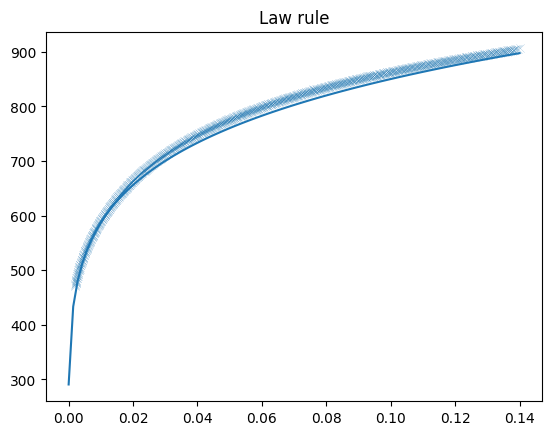

In [415]:
"""--------------------------------------CHECK OF COEFFICIENTS----------------------------------------------"""

foldername = current_dir + "{}_results".format(material) + dir + "DATA" + dir
filename_out = "UT_plasticlaw.csv"
filepath = foldername + filename_out

df_law = pd.read_csv(filepath)

ymod = df_law.iloc[0, df_law.columns.get_loc("YoungModulus")]
ep = df_law["PlasticStrain"].values

sigma = df_law["PlasticStress"].values

def swift(ep):
    return(a * np.power((b + ep), c))

swift = np.vectorize(swift)

def voce(ep):
    return(a - b * (1- np.exp(- c * ep)))

voce = np.vectorize(voce)

fig, ax = plt.subplots(1,1)

X = np.linspace(0, np.max(ep), 100)

if law == "swift" :
    Y = swift(X)
elif law == "voce":
    Y = voce(X)

ax.plot(X, Y)
ax.set_title("Law rule")

ax.scatter(ep, sigma, marker="x", linewidths=0.1 )
plt.show()

In [416]:
"""----------------------------------------------------FIXING PARAMETERS-----------------------------------------------------------------------------"""

a1 = 3
a2 = 3
a3 = 3
a4 = 3
a5 = 3
a6 = 3
b1 = 0
b2 = 0
b3 = 0
b4 = 0
b5 = 0
b6 = 0
b7 = 0
b8 = 0
b9 = 1
b10 = 0
b11 = 0
b12 = 0
b13 = 1
b14 = 1
b15 = 0
b16 = 0
b17 = 0
b18 = 0
b19 = 0
b20 = 1
b21 = 1
b22 = 1

coeff_deg2 = np.array([a1, a2, a3, a4, a5, a6])
coeff_deg4 = np.array([b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, b14, b15, b16, b17, b18, b19, b20, b21, b22])

print("Avant", coeff)

def adapt_coeff(adapt, degree, coeff):
    if adapt :
        if degree == 2:
            return coeff_deg2
        elif degree == 4:
            return coeff_deg4
    return coeff

coeff = adapt_coeff(adapt, degree, coeff)

print("Apres", coeff)

Avant [ 6.63766891  8.65692906 12.77789448  9.04604067  6.13855373 38.47932741
  8.11976737 36.45122004  6.7291342  14.27358534 23.65447189  9.73262885
 15.82823304 10.58554211 -0.37697662 -2.48419646 16.7602714  19.35318044
 16.21577219 17.20846005 20.09398317  7.40532094]
Apres [ 6.63766891  8.65692906 12.77789448  9.04604067  6.13855373 38.47932741
  8.11976737 36.45122004  6.7291342  14.27358534 23.65447189  9.73262885
 15.82823304 10.58554211 -0.37697662 -2.48419646 16.7602714  19.35318044
 16.21577219 17.20846005 20.09398317  7.40532094]


In [417]:
"""----------------------------------------------------TESTING FUNCTIONS (PLOT & CONVEXITY)-----------------------------------------------------------------"""
## WRAP FUNCTION BEFORE USING PLOT IMPLICIT
def plot_implicit(yf, bbox=(-1.5,1.5)):
    ''' create a plot of an implicit function
    fn  ...implicit function (plot where fn==0)
    bbox ..the x,y,and z limits of plotted interval'''
    xmin, xmax, ymin, ymax, zmin, zmax = bbox*3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    A = np.linspace(xmin, xmax, 50) # resolution of the contour
    B = np.linspace(xmin, xmax, 10) # number of slices
    A1,A2 = np.meshgrid(A,A) # grid on which the contour is plotted

    print("Début du plot sur XY")
    for z in B: # plot contours in the XY plane
        X,Y = A1,A2
        Z = yf(X,Y,z) - 1
        cset = ax.contour(X, Y, Z+z, [z], zdir='z')
        # [z] defines the only level to plot for this contour for this value of z
    print("Fin du plot sur XY")
    print("Début du plot sur XZ")
    for y in B: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = yf(X,y,Z) - 1
        cset = ax.contour(X, Y+y, Z, [y], zdir='y')

    print("Fin du plot sur XZ")
    print("Début du plot sur YZ")
    for x in B: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = yf(x,Y,Z) - 1
        cset = ax.contour(X+x, Y, Z, [x], zdir='x')
    print("Fin du plot sur YZ")
    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)

    plt.show()

In [418]:
def plot_implicit_coeff(coeff, bbox=(-1.5,1.5)):
    ''' create a plot of an implicit function
    fn  ...implicit function (plot where fn==0)
    bbox ..the x,y,and z limits of plotted interval'''

    xmin, xmax, ymin, ymax, zmin, zmax = bbox*3
    fig, ax = plt.subplots(nrows = 1, ncols = 3, subplot_kw={"projection":"3d"})
    A = np.linspace(xmin, xmax, 50) # resolution of the contour
    B = np.linspace(xmin, xmax, 10) # number of slices
    A1,A2 = np.meshgrid(A,A) # grid on which the contour is plotted

    def f(S):
        return polyN(S, coeff)

    for i in range(3):

        if i == 0:
            f_plane = lambda x, y, z : f(np.array([x, y, 0, z, 0, 0]))
        elif i == 1:
            f_plane = lambda x, y, z : f(np.array([x, y, 0, 0, z, 0]))
        else :
            f_plane = lambda x, y, z : f(np.array([x, y, 0, 0, 0, z]))
        
        f_plane = np.vectorize(f_plane)

        print("Début du plot sur XY")
        for z in B: # plot contours in the XY plane
            X,Y = A1,A2
            Z = f_plane(X,Y,z) - 1
            ax[i].contour(X, Y, Z+z, [z], zdir='z')
            # [z] defines the only level to plot for this contour for this value of z
        print("Fin du plot sur XY")
        print("Début du plot sur XZ")
        for y in B: # plot contours in the XZ plane
            X,Z = A1,A2
            Y = f_plane(X,y,Z) - 1
            ax[i].contour(X, Y+y, Z, [y], zdir='y')

        print("Fin du plot sur XZ")
        print("Début du plot sur YZ")
        for x in B: # plot contours in the YZ plane
            Y,Z = A1,A2
            X = f_plane(x,Y,Z) - 1
            ax[i].contour(X+x, Y, Z, [x], zdir='x')
        print("Fin du plot sur YZ")
        # must set plot limits because the contour will likely extend
        # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
        # to encompass all values in the contour.
        ax[i].set_zlim3d(zmin,zmax)
        ax[i].set_xlim3d(xmin,xmax)
        ax[i].set_ylim3d(ymin,ymax)

    plt.show()

if plot:
    plot_implicit_coeff(coeff)


In [419]:
"""-----------------------------------------------FURTHER TESTS----------------------------------------------------------"""

def f(S) :
    return(polyN(S, coeff))

X = df[["s11", "s22", "s33", "s12", "s13", "s23"]].values

print("Yield stress values")
print(f(X))



Yield stress values
[0.93957186 0.04305708 0.76915589 0.12980994 0.56596766 0.39637867
 0.25284134 0.35265905 0.99289235 1.10348178 1.05799084 1.00921092
 0.99396317 0.98254345 0.88337717 1.07596786 0.95799274 0.89544604]


In [420]:
"""-------------------------------------------------OUTPUT---------------------------------------------------------------------------------------------"""
def write_coeff_user(coeff, protomodel, degree, material, nb_virtual_pt):
    filename = "{}_deg{}_{}.txt".format(material, degree, protomodel)
    foldername = current_dir + material + "_results" + dir + "COEFF" + dir
    filepath = foldername + filename

    n = len(coeff)
    with open(filepath, "w") as file:
        file.write("#Coefficients poly{} for {} based on {} points from the {} protomodel\n".format(degree, material, nb_virtual_pt, protomodel))
        file.write("Number of coefficients : {}\n".format(n))
        for i in range(n):
            file.write("{} : {}\n".format(i + 1, coeff[i]))
            
def write_coeff_abq(coeff, protomodel, degree, material):
    filename = "{}_abq_deg{}_{}.inp".format(material, degree, protomodel)
    foldername = current_dir + material + "_results" + dir + "COEFF" + dir
    filepath = foldername + filename

    n = len(coeff)
    with open(filepath, "w") as file:
        file.write("*USER MATERIAL, constants={}\n".format(7 + nmon_abq))
        file.write("{}, {}, {}, {}, {}, {}, {}, ".format(ymod, enu, a, b, c, degree, nmon_abq))
        n0 = 0
        n0_abq = 0
        while n0_abq < nmon :
            for m in range(0, degree + 1):
                for l in range(0, degree + 1 - m):
                    for k in range(0, degree + 1 - m - l):
                        for j in range(0, degree + 1 - m - l - k):
                            i = degree - m - l - k - j
                            i0, j0, k0, l0, m0 = powers[n0]
                            if (i==i0) and (j==j0) and (k==k0) and (l==l0) and (m==m0):
                                file.write("{}, ".format(coeff[n0]))
                                n0 = n0 + 1
                            else:
                                file.write("0, ")
                            n0_abq = n0_abq + 1
                            if (n0_abq + 7) % 8 == 0:
                                file.write("\n")
                            
        file.write("\n")
        file.write("*DENSITY\n")
        file.write("{}".format(density))


In [421]:
if export_coeff_user:
    write_coeff_user(coeff, protomodel, degree, material, nb_virtual_pt)
if export_coeff_abq:
    write_coeff_abq(coeff, protomodel, degree, material)